In [1]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy.matlib import repmat
from numpy.random import choice

from timeit import default_timer as timer

import tqdm

import scipy

from handythread import foreach
import cython

#import warnings
#warnings.filterwarnings("ignore")

In [2]:
# Turn and recover vector for encoding

def encode(var_dictionary):
    result_concat = np.concatenate([var_dictionary[v].ravel() for v in var_dictionary.keys()])
    return result_concat


def decode(var_vector, var_dictionary):
    result_decoded = {}
    var_idx = [var_dictionary[v].ravel().shape[0] for v in var_dictionary.keys()]

    current_index = 0
    dictionary_names = list(var_dictionary.keys())
    
    for idx in np.arange(len(dictionary_names)):
        result_index = current_index + var_idx[idx]
        result_decoded[dictionary_names[idx]] = np.reshape(var_vector[current_index:result_index], 
                                                           var_dictionary[dictionary_names[idx]].shape)
        
        current_index = result_index
        
    return result_decoded

In [3]:
# Objective functions
# aux function
def _storDegCost(val, par, s, t):
    # Calculate D
    # D = (SoC_max - SoC_min) / Nseg
    segment_interval = par['storInfo'][s, 5] / len(par['storPieceSegments'])

    # First we need to define an auxiliary function for the Ce
    def aux_ce(s, soc):
        if soc < 1:
            return 0

        return  par['storCapCost'][s] / (soc * par['storCyclesMult'][s])

    def aux_ce_approx(t, k):
        return sum([val['storSegXo'][s, t, p] * aux_ce(s, (p)*segment_interval) + k[p] * val['storSegSoC'][s, t, p]
                    for p in np.arange(len(par['storPieceSegments']))])

    def aux_soc(t):
        return m['storEnerState'][s, t-1] - m['storDchActPower'][s, t]/(par['storInfo'][s, 8]/100)


    # Slopes are independent of time
    # Calculate the different slopes
    # K = (Ce(SoC_min + D*s) - Ce(SoC_min + D*(s-1)))/D
    slopes = []
    for i in np.arange(1, len(par['storPieceSegments']) + 1):
        temp_soc1 = segment_interval * i
        temp_soc2 = segment_interval * (i - 1)

        slope = (aux_ce(s=s, soc=temp_soc1) - aux_ce(s=s, soc=temp_soc2)) / segment_interval
        slopes.append(slope)


    # Go through the timesteps - immediately append 0 when charging
    storage_costs = [0]
    for ind in range(1, val['storSegXo'].shape[1]):
        current_cost = aux_ce_approx(ind, slopes)
        previous_cost = aux_ce_approx(ind-1, slopes)

        storage_costs.append(current_cost - previous_cost)
    #print(storage_costs)

    return sum(storage_costs)


def _v2gDegCost(val, par, v, t):
    # Calculate D
    # D = (SoC_max - SoC_min) / Nseg
    segment_interval = par['v2gInfo'][v, 4] / len(par['storPieceSegments'])

    # First we need to define an auxiliary function for the Ce
    def aux_ce(v, soc):
        if soc < 1:
            return 0

        return  par['v2gCapCost'][v] / (soc * par['v2gCyclesMult'][v])


    def aux_ce_approx(t, k):
        return sum([val['v2gSegXo'][v, t, p] * aux_ce(v, (p)*segment_interval) + k[p] * val['v2gSegSoC'][v, t, p]
                    for p in np.arange(len(par['storPieceSegments']))])

    def aux_soc(t):
        return val['v2gEnerState'][v, t-1] - val['v2gDchActPower'][v, t]/(par['v2gInfo'][v, 8])

    # Slopes are independent of time
    # Calculate the different slopes
    # K = (Ce(SoC_min + D*s) - Ce(SoC_min + D*(s-1)))/D
    slopes = [0]
    for i in np.arange(1, len(par['storPieceSegments'])):
        temp_soc1 = segment_interval * i
        temp_soc2 = segment_interval * (i - 1)

        slope = (aux_ce(v=v, soc=temp_soc1) - aux_ce(v=v, soc=temp_soc2)) / segment_interval
        slopes.append(slope)


    # Go through the timesteps - immediately append 0 when charging
    storage_costs = [0]
    for ind in np.arange(1, val['v2gSegXo'].shape[1]):
        current_cost = aux_ce_approx(ind, slopes)
        previous_cost = aux_ce_approx(ind-1, slopes)

        storage_costs.append(current_cost - previous_cost)
    #print(storage_costs)

    return sum(storage_costs)


class FunctionCompilation():
    # feval equivalent
    def callFunction(self, name, val):
        fn = getattr(self, name, None)
        if fn is not None:
            return fn(val)
        else:
            print('Undefined function call')
            return
        
        
    def ackley(self, val):
        dim = val.shape[1]
        
        f1 = np.sum([val[:, :1 + dim]**2], axis=-1)
        f1 = np.reshape(f1, (f1.shape[1], f1.shape[0]))
        f2 = np.sum([np.cos(2*np.pi * val[:, :1+dim])], axis=-1)
        f2 = np.reshape(f2, (f2.shape[1], f2.shape[0]))
        
        return -20 * np.exp(-0.2 * np.sqrt(1/dim * f1)) - np.exp(1/dim * f2) + 20 + np.exp(1)
        
    
    def eso_obj(self, val):
        par = val['par']
        
        vals = val['var']
        
        i: cython.int
            
        t: cython.int
        g: cython.int
        l: cython.int
        s: cython.int
        v: cython.int
            
            
        t_range: cython.int[par['t'].shape[0]] = range(par['t'].shape[0])
        gen_range: cython.int[par['gen'].shape[0]] = range(par['gen'].shape[0])
        load_range: cython.int[par['load'].shape[0]] = range(par['load'].shape[0])
        stor_range: cython.int[par['stor'].shape[0]] = range(par['stor'].shape[0])
        v2g_range: cython.int[par['v2g'].shape[0]] = range(par['v2g'].shape[0])
            
        
        obj_value = []
        
        if len(vals.shape) < 2:
            vals = np.reshape(vals, (1, vals.shape[0]))
        
        for i in np.arange(vals.shape[0]):
            var = decode(vals[i, :], val['var_names'])
        
            # Balance vectors
            balance_gens = []
            balance_loads = []
            balance_stor = []
            balance_v2g = []
            
            # Hourly balance
            for t in t_range:
                b_gens = np.sum([var['genActPower'][g, t] - var['genExcActPower'][g, t] 
                                 for g in gen_range])
                balance_gens.append(b_gens)
            
                b_loads = np.sum([par['loadActPower'][l, t] - var['loadRedActPower'][l, t] - var['loadCutActPower'][l, t] - var['loadENS'][l, t]
                                  for l in load_range])
                balance_loads.append(b_loads)

                b_stor = np.sum([var['storChActPower'][s, t] - var['storDchActPower'][s, t]
                                 for s in stor_range])
                balance_stor.append(b_stor)

                b_v2g = np.sum([var['v2gChActPower'][v, t] - var['v2gDchActPower'][v, t]
                                for v in v2g_range])
                balance_v2g.append(b_v2g)
                
                
            # Turn to array
            balance_gens = np.array(balance_gens)
            balance_loads = np.array(balance_loads)
            balance_stor = np.array(balance_stor)
            balance_v2g = np.array(balance_v2g)
            
            # balance_rest -> tornar vector
            balance_rest = balance_gens - balance_loads - balance_stor - balance_v2g
            
            
            # Balances and import/export penalties
            mask = balance_rest > 0
            var['pImp'][mask] *= 0
            var['pExp'][mask] = balance_rest[mask]
            
            mask = balance_rest < 0
            var['pExp'][mask] *= 0
            var['pImp'][mask] = abs(balance_rest)[mask]
            
            
            # Attribute penalties for import/export
            balance_penalty = 0
            for t in t_range:
                if (var['pImp'][t] > par['pImp'][t]):
                    balance_penalty += 100000
                
                if (var['pExp'][t] > par['pExp'][t]):
                    balance_penalty += 100000
                    
            
            # EV EnerState requirements penalty
            #v2g_penalty = np.sum([1000 if var['v2gEnerState'][v, t] < par['v2gLimit'][v, t, 2] else 0
            #                      for t in t_range for v in v2g_range])
                    
                    
            # Objective function values
            temp_gens = sum([var['genActPower'][g, t] * par['genLimit'][g, t, 2] + var['genExcActPower'][g, t] * par['genLimit'][g, t, 4]
                             for t in t_range for g in gen_range])
            
            temp_loads = sum([var['loadRedActPower'][l, t] * par['loadLimit'][l, t, 6] + var['loadCutActPower'][l, t] * par['loadLimit'][l, t, 7] + var['loadENS'][l, t] * par['loadLimit'][l, t, 9] 
                              for t in t_range for l in load_range])
            
            temp_stor = sum([var['storDchActPower'][s, t] * par['storLimit'][s, t, 3] - var['storChActPower'][s, t] * par['storLimit'][s, t, 2] + var['EminRelaxStor'][s, t] * 200 
                             for t in t_range for s in stor_range])
            
            temp_v2g = sum([var['v2gDchActPower'][v, t] * par['v2gLimit'][v, t, 6] - var['v2gChActPower'][v, t] * par['v2gLimit'][v, t, 5]# + var['EminRelaxEv'][v, t] * 200
                            for t in t_range for v in v2g_range])
    
            temp_rest = sum([var['pImp'][t] * par['buyPrice'][t] - var['pExp'][t] * par['sellPrice'][t] 
                             for t in t_range])    
            
            temp_storDeg = sum([_storDegCost(var, par, s, t) for t in t_range for s in stor_range])
            
            temp_v2gDeg = sum([_v2gDegCost(var, par, v, t) for v in t_range for v in v2g_range])
            
            obj_value.append((temp_gens + temp_loads + temp_stor + temp_v2g + temp_rest)*1.0 + balance_penalty + temp_storDeg + temp_v2gDeg)# + v2g_penalty)
            
        obj_value = np.reshape(obj_value, (vals.shape[0], 1))
        
        return obj_value

In [4]:
# HyDE-DF parameters

class DEParams(object):
    
    def __init__(self, I_itermax=5e5, I_NP=50, F_weight=0.5, F_CR=0.9, I_bnd_constr=3, param_dictionary=None):
        
        ## Set parameters for HyDE-DF
        self.I_itermax = I_itermax
        self.I_NP = I_NP
        self.F_weight = F_weight
        self.F_CR = F_CR
        
        self.param_dictionary = None
        
        self.I_bnd_constr = I_bnd_constr #Using bound constraints is possible to change direct in DE
        # 1 repair to the lower or upper violated bound
        # 2 rand value in the allowed range
        # 3 bounce back
        
        return
        
        
class OtherParameters(object):
    
    def __init__(self, objfun, dim, lowerlimit, upperlimit, 
                 var_dictionary=None,
                 param_dictionary=None,
                 initial_solution=None, decoded_initialSolution=None):
        self.objfun = objfun
        self.dim = dim
        self.lowerlimit = lowerlimit
        self.upperlimit = upperlimit
        
        self.var_dictionary = var_dictionary
        
        self.param_dictionary = param_dictionary
        
        self.initial_solution = initial_solution
        self.decoded_initialSolution = decoded_initialSolution
        
        return

In [5]:
# Check regular storage degradation

def check_pop_storDeg(val, par, val_dictionary):
    
    # Decode the solution vector
    pop = decode(val, val_dictionary)
    
    s: cython.int
    t: cython.int
    p: cython.int
    segment_interval: cython.float
    mask = None
    
    # Bound and restrict the binary variables
    for s in range(pop['storSegXo'].shape[0]):
        for t in range(pop['storSegXo'].shape[1]):
            bin_max = np.argmax(pop['storSegXo'][s, t, :])
            bin_vals = np.zeros(shape=(pop['storSegXo'].shape[2]))
            bin_vals[bin_max] = 1
            pop['storSegXo'][s, t, :] = bin_vals
    
    # Min and max value SoC constraints
    mask = pop['storSegSoC'] < 0
    pop['storSegSoC'][mask] = 0
    
    # Need a cycle due to variable shapes
    for s in range(pop['storSegSoC'].shape[0]):
        segment_interval = par['storInfo'][s, 5] / len(par['storPieceSegments'])
        
        mask = pop['storSegSoC'][s, :, :] > segment_interval * pop['storSegSoC'][s, :, :]
        pop['storSegSoC'][s, :, :][mask] = segment_interval * pop['storSegSoC'][s, :, :][mask]
        
        
    segSoC: cython.float
    # Fix the storSegSoC in case they don't match the original SoC
    for s in range(pop['storSegSoC'].shape[0]):
        # Segment interval calculation (D)
        segment_interval = par['storInfo'][s, 5] / len(par['storPieceSegments'])
        
        for t in range(pop['storSegSoC'].shape[1]):
            
            # sum only until element before last
            segSoC = sum([pop['storSegSoC'][s, t, p-1] + (p-1)*segment_interval*pop['storSegXo'][s, t, p-1]
                          for p in range(1, pop['storSegSoC'].shape[2] - 1)])
            
            
            # last element separately - just for reference
            #lastSegSoC = pop['storSegSoC'][s, t, -1] + (pop['storSegSoC'].shape[2]-1)*pop['storSegXo'][s, t, -1]
            remainingSoC = (pop['storSegSoC'].shape[2]-1)*pop['storSegXo'][s, t, -1]
            
            pop['storSegSoC'][s, t, -1] = pop['storEnerState'][s, t] - (segSoC + remainingSoC)
    
    return encode(pop)  

In [6]:
# Check V2G storage degradation

def check_pop_v2gDeg(val, par, val_dictionary):
    
    # Decode the solution vector
    pop = decode(val, val_dictionary)
    
    v: cython.int
    t: cython.int
    p: cython.int
    segment_interval: cython.float
    mask = None
    
    for v in range(pop['v2gSegXo'].shape[0]):
        for t in range(pop['v2gSegXo'].shape[1]):
            # Bound and restrict the binary variables
            bin_max = np.argmax(pop['v2gSegXo'][v, t, :])
            bin_vals = np.zeros(shape=(pop['v2gSegXo'].shape[2]))
            bin_vals[bin_max] = 1
            pop['v2gSegXo'][v, t, :] = bin_vals
    
    # Min and max value SoC constraints
    mask = pop['v2gSegSoC'] < 0
    pop['v2gSegSoC'][mask] = 0
    
    # Need a cycle due to variable shapes
    for v in range(pop['v2gSegSoC'].shape[0]):
        segment_interval = par['v2gInfo'][v, 4] / len(par['storPieceSegments'])
        
        mask = pop['v2gSegSoC'][v, :, :] > segment_interval * pop['v2gSegSoC'][v, :, :]
        pop['v2gSegSoC'][v, :, :][mask] = segment_interval * pop['v2gSegSoC'][v, :, :][mask]
        
        
    segSoC: cython.float
    # Fix the storSegSoC in case they don't match the original SoC
    for v in range(pop['v2gSegSoC'].shape[0]):
        # Segment interval calculation (D)
        segment_interval = par['v2gInfo'][v, 4] / len(par['storPieceSegments'])
        
        for t in range(pop['v2gSegSoC'].shape[1]):
            
            # sum only until element before last
            segSoC = sum([pop['v2gSegSoC'][v, t, p-1] + (p-1)*segment_interval*pop['v2gSegXo'][v, t, p-1]
                          for p in range(1, pop['v2gSegSoC'].shape[2] - 1)])
            
            
            # last element separately - just for reference
            #lastSegSoC = pop['storSegSoC'][s, t, -1] + (pop['storSegSoC'].shape[2]-1)*pop['storSegXo'][s, t, -1]
            remainingSoC = (pop['v2gSegSoC'].shape[2]-1)*pop['v2gSegXo'][v, t, -1]
            
            pop['v2gSegSoC'][v, t, -1] = pop['v2gEnerState'][v, t] - (segSoC + remainingSoC)
    
    return encode(pop)  

In [168]:
# Class to speed up code execution

class HeuristicData(object):
    def __init__(self):
        return
    
    
    def objectiveFunction(self):
        return
    
    
    def doIteration(self):
        return
    
    
    def newIteration(self):
        return
    

class EnergyCommunity(HeuristicData):
    
    def __init__(self, parameters, variables):
        # Set initial values
        self.__initial_variables__ = variables
        self.__var_idx__ = [variables[v].ravel().shape[0] for v in variables.keys()]
        self.__var_names__ = list(variables.keys())
        
        self.parameterAssign(parameters)
        self.variableAssign(variables)
        
        self.encoded = None
        self.decoded = None
        
        
        self.objFn = 0
        
        self.checkV2G()
        self.checkCS()
        return
    
    
    def parameterAssign(self, parameters):
        self.genLimit = parameters['genLimit']
        self.genInfo = parameters['genInfo']
        self.pImpMax = parameters['pImpMax']
        self.pExpMax = parameters['pExpMax']
        self.loadLimit = parameters['loadLimit']
        self.loadActPower = parameters['loadActPower']
        self.storLimit = parameters['storLimit']
        self.storInfo = parameters['storInfo']
        self.v2gLimit = parameters['v2gLimit']
        self.v2gInfo = parameters['v2gInfo']
        self.csLimit = parameters['csLimit']
        self.csInfo = parameters['csInfo']
        self.EV_CS_Info = parameters['EV_CS_Info']
        self.buyPrice = parameters['buyPrice']
        self.sellPrice = parameters['sellPrice']
        self.t = parameters['t']
        self.gen = parameters['gen']
        self.load = parameters['load']
        self.stor = parameters['stor']
        self.v2g = parameters['v2g']
        self.cs = parameters['cs']
        #self.storPieceSegments = parameters['storPieceSegments']
        #self.storCapCost = parameters['storCapCost']
        #self.storCyclesMult = parameters['storCyclesMult']
        #self.v2gCapCost = parameters['v2gCapCost']
        #self.v2gCyclesMult = parameters['v2gCyclesMult']
        
        return
    
    
    def variableAssign(self, variables):
        self.genActPower = variables['genActPower']
        self.genExcActPower = variables['genExcActPower']
        self.pImp = variables['pImp']
        self.pExp = variables['pExp']
        self.loadRedActPower = variables['loadRedActPower']
        self.loadENS = variables['loadENS']
        self.storDchActPower = variables['storDchActPower']
        self.storChActPower = variables['storChActPower']
        self.EminRelaxStor = variables['EminRelaxStor']
        #self.v2gDchActPower = variables['v2gDchActPower']
        #self.v2gChActPower = variables['v2gChActPower']
        self.genXo = variables['genXo']
        self.loadXo = variables['loadXo']
        self.storDchXo = variables['storDchXo']
        self.v2gDchXo = variables['v2gDchXo']
        self.v2gChXo = variables['v2gChXo']
        #self.storSegSoC = self.variables['storSegSoC']
        #self.v2gSegSoC = self.variables['v2gSegSoC']
        #self.storSegXo = self.variables['storSegXo']
        #self.v2gSegXo = self.variables['v2gSegXo']
        
        self.loadCutActPower = np.zeros((len(self.load),
                                         len(self.t)))
        
        self.storEnerState = np.zeros((len(self.stor),
                                       len(self.t)))
        
        return
    
    
    def objectiveFunction(self):
        i: cython.int
        t: cython.int
        g: cython.int
        l: cython.int
        s: cython.int
        v: cython.int
            
        t_range: cython.int[self.t.shape[0]] = range(self.t.shape[0])
        gen_range: cython.int[self.gen.shape[0]] = range(self.gen.shape[0])
        load_range: cython.int[self.load.shape[0]] = range(self.load.shape[0])
        stor_range: cython.int[self.stor.shape[0]] = range(self.stor.shape[0])
        v2g_range: cython.int[self.v2g.shape[0]] = range(self.v2g.shape[0])
            
        balance_gens: cython.float[self.t.shape[0]] = np.zeros(self.t.shape[0])
        balance_loads: cython.float[self.t.shape[0]] = np.zeros(self.t.shape[0])
        balance_stor: cython.float[self.t.shape[0]] = np.zeros(self.t.shape[0])
        balance_v2g: cython.float[self.t.shape[0]] = np.zeros(self.t.shape[0])
            
        for t in t_range:
            balance_gens[t] = np.sum([self.genActPower[g, t] - self.genExcActPower[g, t]
                                      for g in gen_range])
            
            balance_loads[t] = np.sum([self.loadActPower[l, t] - self.loadRedActPower[l, t] - self.loadCutActPower[l, t] - self.loadENS[l, t] 
                                       for l in load_range])
            
            balance_stor[t] = np.sum([self.storChActPower[s, t] - self.storDchActPower[s, t]
                                      for s in stor_range])
            
            balance_v2g[t] = np.sum([self.v2gChActPower[v, t] - self.v2gDchActPower[v, t]
                                     for v in v2g_range])
            
        balance_rest: cython.float[self.t.shape[0]] = balance_gens - balance_loads - balance_stor - balance_v2g
            
        # Balance and import/export penalties
        mask = balance_rest > 0
        self.pImp[mask] *= 0
        self.pExp[mask] = balance_rest[mask]
        
        mask = balance_rest < 0
        self.pExp[mask] *= 0
        self.pImp[mask] = abs(balance_rest)[mask]
        
        
        # Attribute penalties for import/export
        balance_penalty: cython.float = 0
        for t in t_range:
            if (self.pImp[t] > self.pImpMax[t]):
                balance_penalty += 100000
                
            if (self.pExp[t] > self.pExpMax[t]):
                balance_penalty += 100000
                
            
        temp_gens: cython.float = sum([self.genActPower[g, t] * self.genLimit[g, t, 2] + self.genExcActPower[g, t] * self.genLimit[g, t, 4]
                                       for t in t_range for g in gen_range])
            
        temp_loads: cython.float = sum([self.loadRedActPower[l, t] * self.loadLimit[l, t, 6] + self.loadCutActPower[l, t] * self.loadLimit[l, t, 7] + self.loadENS[l, t] * self.loadLimit[l, t, 9] 
                                        for t in t_range for l in load_range])
            
        temp_stor: cython.float = sum([self.storDchActPower[s, t] * self.storLimit[s, t, 3] - self.storChActPower[s, t] * self.storLimit[s, t, 2] + self.EminRelaxStor[s, t] * 200 
                                       for t in t_range for s in stor_range])
            
        temp_v2g: cython.float = sum([self.v2gDchActPower[v, t] * self.v2gLimit[v, t, 6] - self.v2gChActPower[v, t] * self.v2gLimit[v, t, 5] + self.EminRelaxEv[v, t] * 200
                                      for t in t_range for v in v2g_range])
            
        temp_rest: cython.float = sum([self.pImp[t] * self.buyPrice[t] - self.pExp[t] * self.sellPrice[t] 
                                       for t in t_range])   
            
        #temp_storDeg: cython.float = sum([self._auxStorDegCost(s, t) for t in t_range for s in stor_range])
            
        #temp_v2gDeg: cython.float = sum([self._auxV2GDegCost(v, t) for t in t_range for v in v2g_range])
        
        self.objFn = (temp_gens + temp_loads + temp_stor + temp_v2g + temp_rest)*1.0 + balance_penalty# + temp_storDeg + temp_v2gDeg
        return
    
    
    def _auxStorDegCost(self, s, t):
        # Calculate D
        # D = (SoC_max - SoC_min) / Nseg
        segment_interval: cython.float = self.storInfo[s, 5] / len(self.storPieceSegments)
            
        # First we need to define an auxiliary function for the Ce
        def aux_ce(s, soc):
            if soc < 1:
                return 0

            return  self.storCapCost[s] / (soc * self.storCyclesMult[s])
        
        def aux_ce_approx(t, k):
            return sum([self.storSegXo[s, t, p] * aux_ce(s, (p)*segment_interval) + k[p] * self.storSegSoC[s, t, p]
                        for p in range(len(par['storPieceSegments']))])
        
        def aux_soc(t):
            return self.storEnerState[s, t-1] - self.storDchActPower[s, t]/(self.storInfo[s, 8]/100)
        
        # Slopes are independent of time
        # Calculate the different slopes
        # K = (Ce(SoC_min + D*s) - Ce(SoC_min + D*(s-1)))/D
        slopes: cython.float[len(self.storPieceSegments)] = np.zeros(len(self.storPieceSegments))
        for i in np.arange(1, len(par['storPieceSegments']) + 1):
            temp_soc1 = segment_interval * i
            temp_soc2 = segment_interval * (i - 1)

            slope[i-1] = (aux_ce(s=s, soc=temp_soc1) - aux_ce(s=s, soc=temp_soc2)) / segment_interval


        # Go through the timesteps - immediately append 0 when charging
        storage_costs: cython.float[len(self.storSegXo.shape[1])] = np.zeros(len(self.storSegXo.shape[1]))
        for ind in range(1, val['storSegXo'].shape[1]):
            current_cost = aux_ce_approx(ind, slopes)
            previous_cost = aux_ce_approx(ind-1, slopes)

            storage_costs[ind] = (current_cost - previous_cost)
        #print(storage_costs)

        return sum(storage_costs)
    
    
    def _auxV2GDegCost(val, par, v, t):
        # Calculate D
        # D = (SoC_max - SoC_min) / Nseg
        segment_interval: cython.float = self.v2gInfo[v, 4] / len(self.storPieceSegments)

        # First we need to define an auxiliary function for the Ce
        def aux_ce(v, soc):
            if soc < 1:
                return 0

            return  self.v2gCapCost[v] / (soc * self.v2gCyclesMult[v])


        def aux_ce_approx(t, k):
            return sum([self.v2gSegXo[v, t, p] * aux_ce(v, (p)*segment_interval) + k[p] * self.v2gSegSoC[v, t, p]
                        for p in range(len(par['storPieceSegments']))])

        def aux_soc(t):
            return self.v2gEnerState[v, t-1] - self.v2gDchActPower[v, t]/(self.v2gInfo[v, 8])

        # Slopes are independent of time
        # Calculate the different slopes
        # K = (Ce(SoC_min + D*s) - Ce(SoC_min + D*(s-1)))/D
        slopes: cython.float[len(self.storPieceSegments)] = np.zeros(len(self.storPieceSegments))
        for i in np.arange(1, len(par['storPieceSegments'])):
            temp_soc1 = segment_interval * i
            temp_soc2 = segment_interval * (i - 1)

            slope[i-1] = (aux_ce(v=v, soc=temp_soc1) - aux_ce(v=v, soc=temp_soc2)) / segment_interval


        # Go through the timesteps - immediately append 0 when charging
        storage_costs: cython.float[len(self.storSegXo.shape[1])] = np.zeros(len(self.storSegXo.shape[1]))
        for ind in np.arange(1, val['v2gSegXo'].shape[1]):
            current_cost = aux_ce_approx(ind, slopes)
            previous_cost = aux_ce_approx(ind-1, slopes)

            storage_costs[ind] = (current_cost - previous_cost)
        #print(storage_costs)

        return sum(storage_costs)

    
    def doIteration(self):
        self.checkImpExp()
        self.checkGens()
        self.checkLoads()
        self.checkStor()
        #self.checkV2G()
        #self.checkCS()
        
        self.objectiveFunction()
        
        self.encoded = self.encode()
        return
    
    
    def newIteration(self, encoded_vals):
        self.variableAssign(self.decode(encoded_vals))
        self.doIteration()
        return

    
    def checkImpExp(self):
        # Imports
        mask = self.pImp >= self.pImpMax
        self.pImp[mask] = self.pImpMax[mask]
        
        mask = self.pImp < 0
        self.pImp[mask] *= 0
        
        # Exports
        mask = self.pExp > self.pExpMax
        self.pExp[mask] = self.pExpMax[mask]
        
        mask = self.pExp < 0
        self.pExp[mask] *= 0
        
        return
    
    
    def checkGens(self):
        self.genXo = (self.genXo > 0.5).astype(int)
        
        # Maximum generation
        mask = self.genActPower > self.genLimit[:, :, 0]
        self.genActPower[mask] = self.genLimit[:, :, 0][mask]
        
        mask = self.genActPower < 0
        self.genActPower[mask] *= 0
        
        
        # Generator types - type 1
        mask = self.genInfo[:, 1] == np.ones((self.genInfo[:, 1].shape))
        temp_vals = np.ones(self.genActPower.shape).transpose() * self.genInfo[:, 6]
        temp_vals = temp_vals.transpose()
        self.genActPower[mask] = temp_vals[mask]
        self.genExcActPower[mask] = np.zeros((self.genExcActPower.shape))[mask]
        
        # Generator types - type 2
        mask = self.genInfo[:, 1] == 2*np.ones((self.genInfo[:, 1].shape))
        self.genExcActPower[mask] = self.genLimit[mask][:, :, 0] - self.genActPower[mask]
                
        return
    
    
    def checkLoads(self):
        
        # Bound the values to either 0 or 1
        self.loadXo = (self.loadXo > 0.5).astype(int)
        
        # Build a matrix of ones
        temp_vals = np.ones((self.loadRedActPower.shape[0],
                             self.loadRedActPower.shape[1]))
        
        # RedAct value checks
        mask = self.loadRedActPower > temp_vals * self.loadLimit[:, :, 2]
        self.loadRedActPower[mask] = (temp_vals * self.loadLimit[:, :, 2])[mask]
        
        mask = self.loadRedActPower < 0
        self.loadRedActPower[mask] *= 0
        
        # loadCut value checks
        self.loadCutActPower = self.loadLimit[:, :, 3]
        self.loadCutActPower *= self.loadXo
        
        # loadENS
        temp_vals = self.loadActPower - self.loadRedActPower - self.loadCutActPower
        mask = self.loadENS > temp_vals
        self.loadENS[mask] = temp_vals[mask]
        return
    
    
    def checkStor(self):
        
        # Binary variables bound
        self.storChXo = (self.storDchXo < 0.33).astype(int)
        self.storDchXo = (self.storDchXo > 0.66).astype(int)
        
        mask = None
        # Discharge inequality
        mask = self.storDchActPower > self.storLimit[:, :, 1]
        self.storDchActPower[mask] = self.storLimit[:, :, 1][mask]
        
        mask = self.storDchActPower <= 0
        self.storDchActPower[mask] *= 0
        
        # Charge inequality
        mask = self.storChActPower > self.storLimit[:, :, 0]
        self.storChActPower[mask] = self.storLimit[:, :, 0][mask]
        
        mask = self.storChActPower <= 0
        self.storChActPower[mask] *= 0
        
        # Initial stor SoC
        self.storEnerState[:, 0] = self.storInfo[:, 5] * (self.storInfo[:, 9]/100) + self.storChActPower[:, 0] * (self.storInfo[:, 7]/100) - self.storDchActPower[:, 0]/(self.storInfo[:, 8]/100)
        
        t: cython.int
        t_range: cython.int[len(self.t) - 1] = range(1, len(self.t))
        # Fix the timestep dependencies
        for t in t_range:
            # Check if charging
            mask = self.storChXo[:, t] > np.zeros(self.storChXo[:, t].shape)
            charged = self.storChActPower[:, t] * (self.storInfo[:, 7]/100)
            # Prevent charging beyong limit
            secondary_mask = (self.storEnerState[:, t-1] + charged) > self.storInfo[:, 5]
            self.storChActPower[:, t][secondary_mask] = ((self.storInfo[:, 5] - self.storEnerState[:, t-1]) / (self.storInfo[:, 7]/100))[secondary_mask]
            
            # Check if discharging
            mask = self.storDchXo[:, t] > np.zeros(self.storDchXo[:, t].shape)
            discharged = self.storDchActPower[:, t] / (self.storInfo[:, 8]/100)
            secondary_mask = (self.storEnerState[:, t-1] - discharged) < 0
            self.storDchActPower[:, t][secondary_mask] = (self.storEnerState[:, t-1] * (self.storInfo[:, 8]/100))[secondary_mask]
            
            self.storChActPower[:, t] *= self.storChXo[:, t]
            self.storDchActPower[:, t] *= self.storDchXo[:, t]
            self.storEnerState[:, t] = self.storEnerState[:, t-1] + (self.storChActPower[:, t] * (self.storInfo[:, 7]/100)) - (self.storDchActPower[:, t]/(self.storInfo[:, 8]/100))
            
            mask = self.storEnerState[:, t] < self.storInfo[:, 6] * (self.storInfo[:, 5] / 100) - self.EminRelaxStor[:, t]
            self.storEnerState[:, t][mask] = (self.storInfo[:, 6] * (self.storInfo[:, 5] / 100) - self.EminRelaxStor[:, t])[mask]
        return
    
    
    def checkV2G_old(self):
        
        # Binary variables bounding
        self.v2gChXo = (self.v2gDchXo < 0.33).astype(int)
        self.v2gDchXo = (self.v2gDchXo > 0.66).astype(int)
        
        mask = None
        t: cython.int
        t_range: cython.int[len(self.t) - 1] = range(1, len(self.t))
        for t in t_range:
            mask = self.v2gEnerState[:, t-1] == self.v2gInfo[:, 4]
            self.v2gChXo[:, t][mask] *= 0
            self.v2gChActPower[:, t][mask] *= 0
            
            mask = self.v2gEnerState[:, t-1] == 0
            self.v2gDchXo[:, t][mask] *= 0
            self.v2gDchActPower[:, t][mask] *= 0
            
        # Discharge rate
        temp_vals = self.v2gLimit[:, :, 4] * self.v2gLimit[:, :, 0] * self.v2gDchXo
        mask = self.v2gDchActPower > temp_vals
        self.v2gDchActPower[mask] = temp_vals[mask]
        
        
        
        # Charge rate
        temp_vals = self.v2gLimit[:, :, 3] * self.v2gLimit[:, :, 0] * self.v2gChXo
        mask = self.v2gChActPower > temp_vals
        self.v2gChActPower[mask] = temp_vals[mask]
        
        # Energy Balance Initial Eq
        mask = self.v2gLimit[:, 0, 0] == 0
        temp_vals = self.v2gLimit[:, 0, 1] + (self.v2gChActPower[:, 0] * self.v2gInfo[:, 7]) - (self.v2gDchActPower[:, 0] / self.v2gInfo[:, 8])
        self.v2gEnerState[:, 0][mask] = temp_vals[mask]
        
        # Energy Balance 1
        mask = self.v2gLimit[:, :-1, 0] == 1
        secondary_mask = self.v2gLimit[:, 1:, 0] == 1
        
        temp_vals = [self.v2gEnerState[:, t-1] + self.v2gLimit[:, t, 1] + (self.v2gChActPower[:, t] * self.v2gInfo[:, 7]) - (self.v2gDchActPower[:, t] / self.v2gInfo[:, 8])
                     for t in range(1, len(self.t))]
        temp_vals = np.array(temp_vals).transpose()
        self.v2gEnerState[:, 1:][mask & secondary_mask] = temp_vals[mask & secondary_mask]
        
        # Energy Balance 2
        mask = self.v2gLimit[:, :-1, 0] == 0
        temp_vals = [self.v2gLimit[:, t, 1] + (self.v2gChActPower[:, t] * self.v2gInfo[:, 8]) + (self.v2gDchActPower[:, t] / self.v2gInfo[:, 8])
                     for t in range(1, len(self.t))]
        temp_vals = np.array(temp_vals).transpose()
        self.v2gEnerState[:, 1:][mask & secondary_mask] = temp_vals[mask & secondary_mask]
        return
    
    
    def checkV2G(self):
        # Binary variables bounding
        #self.v2gChXo = (self.v2gDchXo < 0.33).astype(int)
        #self.v2gDchXo = (self.v2gDchXo > 0.66).astype(int)
        
        self.v2gDchActPower = np.zeros((len(self.v2g),
                                        len(self.t)))
        
        self.v2gChActPower = np.zeros((len(self.v2g),
                                       len(self.t)))
        
        self.v2gEnerState = np.zeros((len(self.v2g),
                                      len(self.t)))
        
        self.EminRelaxEv = np.zeros((len(self.v2g),
                                     len(self.t)))
        
        # Bound binary variables
        self.v2gChXo = (self.v2gChXo > 0.5).astype(int)
        self.v2gDchXo = (self.v2gDchXo > 0.5).astype(int)
        #self.v2gChXo = 1 - self.v2gDchXo

        mask = None

        v: cython.int
        c: cython.int

        # Discharge rate
        #temp_val = par['v2gLimit'][:, :, 4] * par['v2gLimit'][:, :, 0]
        #mask = pop['v2gDchActPower'] > temp_val
        #pop['v2gDchActPower'][mask] = temp_val[mask]


        # Charge rate
        #temp_val = par['v2gLimit'][:, :, 3] * par['v2gLimit'][:, :, 0]
        #mask = pop['v2gChActPower'] > temp_val
        #pop['v2gChActPower'][mask] = temp_val[mask]

        self.v2gDchActPower = self.v2gLimit[:, :, 4] * self.v2gLimit[:, :, 0]
        self.v2gChActPower = self.v2gLimit[:, :, 3] * self.v2gLimit[:, :, 0]

        # V2G constraints
        v_range: cython.int[len(self.v2g)] = range(len(self.v2g))
        c_range: cython.int[len(self.cs)] = range(len(self.cs))
        for v in v_range:
            # Check connection to charging stations
            isConnected = False
            connectedTo = 0

            # Check the charging stations
            for c in c_range:
                isConnected = True
                if self.EV_CS_Info[v, c, 0] > 0:
                    self.v2gChActPower[v, 0] = min(self.v2gChActPower[v, 0], self.csInfo[c, 4])
                    self.v2gDchActPower[v, 0] = min(self.v2gDchActPower[v, 0], self.csInfo[c, 5])

                    connectedTo = c
                else:
                    self.v2gDchXo[v, 0] = 0
                    self.v2gChXo[v, 0] = 0

            if self.v2gChXo[v, 0] + self.v2gDchXo[v, 0] > 1:
                self.v2gDchXo[v, 0] = 1 - self.v2gChXo[v, 0]

            mask = self.v2gLimit[v, :, 2] > 0
            temp_val = self.v2gLimit[v, :, 2][mask]

            if isConnected & (len(temp_val) > 0):
                if self.v2gEnerState[v, 0] < temp_val[0]:
                    next_index = next((idx for idx, val in np.ndenumerate(self.v2gLimit[v, :, 2]) 
                                       if val==temp_val[0]))[0]
                    min_tsteps = np.ceil((temp_val[0] - self.v2gEnerState[v, 0]) / self.csInfo[connectedTo, 4]) - 1

                    if min_tsteps >= next_index:
                        self.v2gChXo[v, 0] = 1
                        self.v2gDchXo[v, 0] = 0

            self.v2gChActPower[v, 0] *= self.v2gChXo[v,  0]
            self.v2gDchActPower[v, 0] *= self.v2gDchXo[v, 0]

            if self.v2gLimit[v, 0, 0] == 0:
                self.v2gEnerState[v, 0] = 0
            elif self.v2gLimit[v, 0, 0] == 1:
                self.v2gEnerState[v, 0] = self.v2gLimit[v, 0, 1] + self.v2gChActPower[v, 0] * self.v2gInfo[v, 7] - self.v2gDchActPower[v, 0] / self.v2gInfo[v, 8]

            #print('v2gEnerState: {}'.format(pop['v2gEnerState'][v, 0]))

            # Timestep
            for t in range(1, len(self.t)):

                isConnected = False
                connectedTo = 0

                # Check the charging stations
                for c in c_range:
                    if self.EV_CS_Info[v, c, t] > 0:
                        isConnected = True
                        self.v2gChActPower[v, t] = min(self.v2gChActPower[v, t], self.csInfo[c, 4])
                        self.v2gDchActPower[v, t] = min(self.v2gDchActPower[v, t], self.csInfo[c, 5])

                        connectedTo = c
                    else:
                        self.v2gDchXo[v, t] = 0
                        self.v2gChXo[v, t] = 0


                # Disable charge and discharge in the same period
                if self.v2gChXo[v, t] + self.v2gDchXo[v, t] > 1:
                    self.v2gDchXo[v, t] = 1 - self.v2gChXo[v, t]

                # Incentivise charge to meet minimum limits
                mask = self.v2gLimit[v, t:, 2] > 0
                temp_val = self.v2gLimit[v, t:, 2][mask]

                # Check if there are any requirements for EVs
                if isConnected & (len(temp_val) > 0):
                    if self.v2gEnerState[v, t-1] < temp_val[0]:
                        next_index = next((idx for idx, val in np.ndenumerate(self.v2gLimit[v, t:, 2]) 
                                           if val==temp_val[0]))[0]
                        min_tsteps = np.ceil((temp_val[0] - self.v2gEnerState[v, t-1])  /  self.csInfo[connectedTo, 4]) - 1
                        if min_tsteps <= next_index:
                            self.v2gChXo[v, t] = 1
                            self.v2gDchXo[v, t] = 0



                            if (self.v2gEnerState[v, t-1] + (self.v2gChActPower[v, t] * float(self.v2gInfo[v, 7]))) >= self.v2gInfo[v, 4]:
                                self.v2gChActPower[v, t] = (self.v2gInfo[v, 4] - self.v2gEnerState[v, t-1]) / float(self.v2gInfo[v, 7])

                # Prevent charging when battery is full
                if self.v2gEnerState[v, t-1] == self.v2gInfo[v, 4]:
                    #print('HERE')
                    self.v2gChXo[v, t] = 0

                # Prevent discharge when battery is empty
                elif self.v2gEnerState[v, t-1] == 0:
                    self.v2gDchXo[v, t] = 0

                self.v2gChActPower[v, t] *= self.v2gChXo[v, t]
                self.v2gDchActPower[v, t] *= self.v2gDchXo[v, t]

                # Update battery capacity
                if (self.v2gLimit[v, t-1, 0] == 1) & (self.v2gLimit[v, t, 0] == 1):
                    self.v2gEnerState[v, t] = self.v2gEnerState[v, t-1] + self.v2gLimit[v, t, 1] + (self.v2gChActPower[v, t] * float(self.v2gInfo[v, 7])) - (self.v2gDchActPower[v, t] / float(self.v2gInfo[v, 8]))
                elif (self.v2gLimit[v, t-1, 0] == 0) & (self.v2gLimit[v, t, 0] == 1):
                    self.v2gEnerState[v, t] = self.v2gLimit[v, t, 1] + (self.v2gChActPower[v, t] * float(self.v2gInfo[v, 7])) + (self.v2gDchActPower[v, t] / float(self.v2gInfo[v, 8]))

        return
    
    
    def checkCS(self):
        
        self.csActPower = np.zeros((len(self.cs),
                                    len(self.t)))
        
        self.csActPowerNet = np.zeros((len(self.cs),
                                       len(self.t)))
        
        self.v2gChXo = (self.v2gDchXo < 0.33).astype(int)
        self.v2gDchXo = (self.v2gDchXo > 0.66).astype(int)
        
        
        c: cython.int
        t: cython.int
        v: cython.int
            
        t_range: cython.int[len(self.t)] = range(len(self.t))
        c_range: cython.int[len(self.cs)] = range(len(self.cs))
        v_range: cython.int[len(self.v2g)] = range(len(self.v2g))
        
        # Timesteps
        for t in t_range:

            # Charging station constraints
            for c in c_range:

                temp_val = 0
                temp_val2 = 0
                for v in v_range:
                    if self.EV_CS_Info[v, c, t] > 0:
                        temp_val += (self.v2gChActPower[v, t]  - self.v2gDchActPower[v, t])
                        temp_val2 += (self.v2gChActPower[v, t] / (self.csInfo[c, 6] / 100) - (self.v2gDchActPower[v, t] * self.csInfo[c, 7] / 100))


                if temp_val > self.csInfo[c, 4]:
                    temp_val = self.csInfo[c, 4]
                if temp_val < -self.csInfo[c, 5]:
                    temp_val = -self.csInfo[c, 5]

                self.csActPower[c, t] = temp_val
                self.csActPowerNet[c, t] = temp_val2
        return
    
    
    def encode(self):
        var_dictionary = {'genActPower': self.genActPower,
                          'genExcActPower': self.genExcActPower,
                          'pImp': self.pImp,
                          'pExp': self.pExp,
                          'loadRedActPower': self.loadRedActPower,
                          'loadENS': self.loadENS,
                          'storDchActPower': self.storDchActPower,
                          'storChActPower': self.storChActPower,
                          'EminRelaxStor': self.EminRelaxStor,
                          #'v2gDchActPower': self.v2gDchActPower,
                          #'v2gChActPower': self.v2gChActPower,
                          'genXo': self.genXo,
                          'loadXo': self.loadXo,
                          'storDchXo': self.storDchXo,
                          'v2gDchXo': self.v2gDchXo,
                          'v2gChXo': self.v2gChXo
                         }
        
        result_concat = np.concatenate([var_dictionary[v].ravel() for v in var_dictionary.keys()])
        return result_concat
    
    
    def decode(self, new_variables):
        result_decoded = {}
        current_index = 0
        
        for idx in range(len(self.__var_names__)):
            result_index = current_index + self.__var_idx__[idx]
            result_decoded[self.__var_names__[idx]] = np.reshape(new_variables[current_index:result_index],
                                                                 self.__initial_variables__[self.__var_names__[idx]].shape)
            
            current_index = result_index
        
        
        return result_decoded
    

In [162]:
# HyDE-DF implementation

def HyDE_DF_Refactored(deParameters, otherParameters, initialSolution):
    
    # Generate population
    def genpop(a, b, lowMatrix, upMatrix):
        #temp = np.random.uniform(low=lowMatrix, high=upMatrix, size=(a, b))
        temp = np.random.random(size=(a, b))
        #temp[np.where(temp < 0)] = 0
        
        # Lower bound
        mask = temp < lowMatrix
        temp[mask] = lowMatrix[mask]
        
        # Upper bounds
        mask = temp > upMatrix
        temp[mask] = upMatrix[mask]

        return temp
    
    def genpop2(a, b, lowMatrix, upMatrix, solution):
        temp = np.random.random(size=(a, b))
        temp += solution
        
        # Lower bounds
        mask = temp < lowMatrix
        temp[mask] = lowMatrix[mask]
        
        # Upper bounds
        mask = temp > upMatrix
        temp[mask] = upMatrix[mask]
        
        return temp
         
    # Trial generation
    def generate_trial(F_weight, F_CR, FM_pop, FVr_bestmemit, I_NP, I_D, FVr_rot, linear_decrease):
    
        # Save the old population
        FM_popold: cython.float[F_weight[:, 2] * I_D] = FM_pop

        # Index pointer array
        FVr_ind = np.random.permutation(np.arange(5))

        # Shuffle locations of vectors
        FVr_a1 = np.random.permutation(np.arange(I_NP))

        # Rotate indices by ind[0] positions
        FVr_rt = (FVr_rot + FVr_ind[0]) % I_NP

        # Rotate vector locations
        FVr_a2 = FVr_a1[FVr_rt]

        # Shuffled population 1
        FM_pm1 = FM_popold[FVr_a1, :]

        # Shuffled population 2
        FM_pm2 = FM_popold[FVr_a2, :]
        
        FM_mpo = None

        # Meaning the same F_CR for all individuals
        if len(F_CR) == 1:

            # All random numbers < F_CR are 1, 0 otherwise
            FM_mui = (np.random.normal(size=(I_NP, I_D)) < F_CR).astype(int)

            # Inverse mask to FM_mui
            FM_mpo = (FM_mui < 0.5).astype(int)

        # Meaning a different F_CR for each individual
        else:
            # All random numbers < F_CR are 1, 0 otherwise
            FM_mui = (np.random.normal(size=(I_NP, I_D)) < repmat(F_CR, 1, I_D)).astype(int)

            # Inverse mask to FM_mui
            FM_mpo = (FM_mui < 0.5).astype(int)


        #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 
        FM_bm: cython.float[F_weight[:, 2] * I_D] = repmat(FVr_bestmemit, I_NP, 1)

        # Linear decrease
        a = linear_decrease

        # Exponential decreasing function
        ginv: cython.float = np.exp(1-(1/a**2)) 
        
        #differential variation
        repmat0: cython.float[F_weight[:, 2] * I_D] = np.reshape(repmat(F_weight[:, 2], 1, I_D), (F_weight.shape[0], I_D))
        #print('repmat0 shape: {}'.format(repmat0.shape))
        repmat1: cython.float[F_weight[:, 0] * I_D] = np.reshape(repmat(F_weight[:, 0], 1, I_D), (F_weight.shape[0], I_D))
        #print('repmat0 shape: {}'.format(repmat0.shape))
        repmat2: cython.float[F_weight[:, 1] * I_D] = np.reshape(repmat(F_weight[:, 1], 1, I_D), (F_weight.shape[0], I_D))
        #print('repmat0 shape: {}'.format(repmat0.shape))
        
        diff_var: cython.float[F_weight[:, 2] * I_D] = ginv * (repmat1 * (FM_bm * (repmat2 + np.random.normal(size=(I_NP, I_D)) - FM_popold)))
        #print(diff_var.shape)
        
        # gens do tipo 2 considerar genAct = genLimit -> valor inicial

        FM_ui: cython.float[F_weight[:, 2] * I_D] = FM_popold + repmat0 * (FM_pm1 - FM_pm2) + diff_var
            
        #FM_ui: cython.float[F_weight[:, 2] * I_D] = do_crossover(FM_popold, repmat0, FM_pm1, FM_pm2, diff_var, 
        #                                                         otherParameters.var_dictionary)
            #def do_crossover(alpha, f, pop1, pop2, exp_decrease, var_dictionary):

        FM_ui = FM_popold * FM_mpo + FM_ui * FM_mui
        FM_base: cython.float[F_weight[:, 2] * I_D] = FM_bm
        #msg = 'HyDE-DF'
        #print(msg)

        return FM_ui, FM_base, None
            
    
    # Update aux function        
    def _update(p, lowMatrix, upMatrix, BRM, FM_base):
        #print(p.shape)
        if BRM == 1: # Our method
            # [popsize, dim] = size(p)
            #idx = np.where(p < lowMatrix)
            #p[idx[0], idx[1]] = lowMatrix[idx]
            
            mask = p < lowMatrix
            p[mask] = lowMatrix[mask]

            #idx = np.where(p > upMatrix)
            #p[idx] = upMatrix[idx]
            
            mask = p > upMatrix
            p[mask] = upMatrix[mask]
            
        elif BRM == 2: # Random initialization - DOES NOT WORK
            idx = [np.where(p < lowMatrix), np.where(p > upMatrix)]
            replace = np.random.uniform(low=lowMatrix[idx[0][0], idx[0][1]], 
                                        high=upMatrix[idx[1][0], idx[1][1]], 
                                        size=(len(idx), 1))
            p[idx] = replace
        #elif BRM == 3: # Bounce-back
        #    idx = np.where(p < lowMatrix)
        #    new_val = np.random.uniform(low=lowMatrix[idx[0], idx[1]], 
        #                                high=FM_base[idx[0], idx[1]], 
        #                                size=(len(idx[0]), len(idx[1])))
        #    if new_val.shape[0] > 0:
        #        p[idx[0], idx[1]] = new_val[:, 0]
        #        
        #        
        #    idx = np.where(p > upMatrix)
        #    new_val = np.random.uniform(low=FM_base[idx[0], idx[1]], 
        #                                high=upMatrix[idx[0], idx[1]], 
        #                                size=(len(idx[0]), len(idx[1])))
        #    if new_val.shape[0] > 0:
        #        p[idx[0], idx[1]] = new_val[:, 0]
        #        
        #    p[p < 0] = 0
                
            #for member in np.arange(p.shape[0]):
            #    p[member] = check_pop(p[member], 
            #                          otherParameters.param_dictionary, 
            #                          otherParameters.var_dictionary)

        return p
    
    
    #-----This is just for notational convenience and to keep the code uncluttered.--------
    I_NP: cython.int = deParameters.I_NP
    F_weight = deParameters.F_weight
    F_CR: cython.float = deParameters.F_CR
    I_D: cython.int = otherParameters.dim     #Number of variables or dimension
    deParameters.nVariables = I_D
    #FVr_minbound = otherParameters.lowerlimit * np.array(np.ones((1,otherParameters.dim)))
    #FVr_maxbound = otherParameters.upperlimit * np.array(np.ones((1,otherParameters.dim)))
    
    FVr_minbound = otherParameters.lowerlimit
    FVr_maxbound = otherParameters.upperlimit
    
    I_itermax: cython.int = deParameters.I_itermax
    
    
    #Repair boundary method employed
    BRM: cython.int = deParameters.I_bnd_constr     #1: bring the value to bound violated
                                                    #2: repair in the allowed range
                                                    #3: Bounce-back
            
    # Get Objective Function
    #fnc = otherParameters.objfun
    
    # Function caller initialization
    #fn_obj = FunctionCompilation()
    
    #-----Check input variables---------------------------------------------
    if I_NP < 5:
        I_NP = 5
        print('I_NP increased to minimal value 5\n')
    
    if (F_CR < 0) | (F_CR > 1):
        F_CR = 0.5
        print('F_CR should be from interval [0, 1] - set to default value 0.5\n')
        
    if I_itermax <= 0:
        I_itermax = 200
        print('I_itermax should be > 0 - set to default value 200\n')
    
    
    #-----Initialize population and some arrays-------------------------------
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    # pre-allocation of loop variables
    fitMaxVector = np.empty((1, I_itermax))
    fitMaxVector[:] = np.nan
    
    # limit iterations by threshold
    #gen = 0; #iterations
    
    
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #----FM_pop is a matrix of size I_NPx(I_D+1). It will be initialized------
    #----with random values between the min and max values of the-------------
    #----parameters-----------------------------------------------------------
    # FLC modification - vectorization
    minPositionsMatrix = repmat(FVr_minbound, I_NP, 1)
    maxPositionsMatrix = repmat(FVr_maxbound, I_NP, 1)
    deParameters.minPositionsMatrix = minPositionsMatrix
    deParameters.maxPositionsMatrix = maxPositionsMatrix
    
    # generate initial population.  
    FM_pop = genpop2(I_NP, I_D, minPositionsMatrix, maxPositionsMatrix, 
                     otherParameters.initial_solution)
    
    FM_aux = [EnergyCommunity(parameters=otherParameters.param_dictionary, 
                              variables=otherParameters.decoded_initialSolution) for i in range(I_NP)]
    
    #If you want to inject initial solutions
    if otherParameters.initial_solution is not None: 
        FM_aux[0].doIteration()
        FM_pop[0, :] = otherParameters.initial_solution
        for solution_idx in range(1, len(FM_aux)):
            FM_aux[solution_idx].newIteration(FM_pop[solution_idx, :])
        
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #------Evaluate the best member after initialization----------------------
    # Modified by FLC
    #S_val = fn_obj.callFunction(fnc, FM_pop)
    
    S_val = np.array([temp_obj.objFn for temp_obj in FM_aux])
    #print(S_val)
    S_val = S_val.ravel()
    I_best_index = np.argmin(S_val) # This mean that the best individual correspond to the best worst performance
    FVr_bestmemit = FM_pop[I_best_index, :] # best member of current iteration
    
    fitMaxVector[:, 0] = S_val[I_best_index] #We save the mean value and mean penalty value
    
    # The user can decide to save the mean, best, or any other value here
    
    
    #------DE-Minimization------------------------------------------------
    #------FM_popold is the population which has to compete. It is--------
    #------static through one iteration. FM_pop is the newly--------------
    #------emerging population.-------------------------------------------
    FVr_rot  = np.arange(0, I_NP, 1)             # rotating index array (size I_NP)
    
    
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #% HYDE self-adaptive parameters
    F_weight_old = repmat(F_weight, I_NP, 3)
    F_weight = F_weight_old
    F_CR_old = repmat(F_CR, I_NP, 1)
    F_CR = F_CR_old
    
    best_instance = None

    
    #while gen < I_itermax-1:  #%&&  fitIterationGap >= threshold
    #def gen_iter(gen):
    #for gen in rang
    itermax_range: cython.float[itermax] = range(I_itermax)
    
    for gen in tqdm.tqdm(itermax_range):
        #% Calculate decay function factor a = itr / MaxItr; 
        lin_decr: cython.float = (I_itermax - gen) / I_itermax

        #% Update HyDE-DF values              
        value_R = np.random.normal(size=(I_NP, 3))
        ind1 = (value_R < 0.1).astype(int)
        ind1_rev = (value_R >= 0.1).astype(int)
        
        value_R_2 = np.random.normal(size=(I_NP, 1))
        ind2 = (value_R_2 < 0.1).astype(int)
        ind2_rev = (value_R_2 >= 0.1).astype(int)

        F_weight = F_weight_old
        try:
            F_weight[ind1] = (0.1 + np.random.normal(size=(sum(sum(ind1)), 1)) * 0.9)[0]
            F_weight[ind1_rev] = F_weight_old[ind1_rev]
        except:
            pass

        F_CR = F_CR_old
        try:
            F_CR[ind2] = np.random.normal(size=(sum(ind2)[0], 1))[0]
            F_CR[ind2_rev] = F_CR_old[ind2_rev]
        except:
            pass
        #except:
        #    F_CR[ind2] = np.random.normal(size=(sum(ind2)[0], 1))

        #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        FM_ui, FM_base, _ = generate_trial(F_weight, F_CR, FM_pop, FVr_bestmemit, I_NP, I_D, FVr_rot, lin_decr)
        #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

        ## Boundary Control
        FM_ui = _update(FM_ui, minPositionsMatrix, maxPositionsMatrix, BRM, FM_base)

        for candidate in range(I_NP):
            FM_aux[candidate].newIteration(FM_ui[candidate, :])

        S_val_temp = np.array([temp_obj.objFn for temp_obj in FM_aux])
        S_val_temp = S_val_temp.ravel()

        
        
        # Elitist Selection
        ind = np.where(S_val_temp < S_val)
        S_val[ind] = S_val_temp[ind]
        #FM_pop[ind, :] = FM_ui[ind, :]
        #print(ind)
        FM_pop[ind, :] = np.array([temp_obj.encoded for temp_obj in FM_aux])[ind]


        # Update best results
        S_bestval = min(S_val)
        I_best_index = np.argmin(S_val)
        best_instance = FM_aux[I_best_index]
        FVr_bestmemit = FM_pop[I_best_index, :]

        # Save best parameters (similar to jDE)
        F_weight_old[ind, :] = F_weight[ind, :]
        F_CR_old[ind] = F_CR[ind]  

        ## Store fitness evolution and obj fun evolution as well
        fitMaxVector[:, gen] = S_bestval
        
    Fit_and_p = fitMaxVector[0, gen]
    
    return Fit_and_p, FVr_bestmemit, fitMaxVector, best_instance

# Show solutions

trial_results

In [9]:
# loadmat aux function to load the matlab save files
# from: https://stackoverflow.com/review/suggested-edits/21667510

import numpy as np
import scipy
import scipy.io as spio

def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    def _check_keys(d):
        '''
        checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        '''
        for key in d:
            if isinstance(d[key], spio.matlab.mio5_params.mat_struct):
                d[key] = _todict(d[key])
        return d

    def _has_struct(elem):
        """Determine if elem is an array and if any array item is a struct"""
        return isinstance(elem, np.ndarray) and any(isinstance(
                    e, scipy.io.matlab.mio5_params.mat_struct) for e in elem)

    def _todict(matobj):
        '''
        A recursive function which constructs from matobjects nested dictionaries
        '''
        d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, spio.matlab.mio5_params.mat_struct):
                d[strg] = _todict(elem)
            elif _has_struct(elem):
                d[strg] = _tolist(elem)
            else:
                d[strg] = elem
        return d

    def _tolist(ndarray):
        '''
        A recursive function which constructs lists from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        '''
        elem_list = []
        for sub_elem in ndarray:
            if isinstance(sub_elem, spio.matlab.mio5_params.mat_struct):
                elem_list.append(_todict(sub_elem))
            elif _has_struct(sub_elem):
                elem_list.append(_tolist(sub_elem))
            else:
                elem_list.append(sub_elem)
        return elem_list
    data = scipy.io.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

In [10]:
# Matlab code conversion

# Read matlab file instead of excelfile (easier conversion)
data = loadmat('matlab.mat')

In [11]:
# Linearize the generator prices

# genCofA=data.generator.limit(:,:,6); -> MATLAB starts with 1, so we need the index -1
# genCofB=data.generator.limit(:,:,7);
# genCofC=data.generator.limit(:,:,8);

genCofA = data['data']['generator']['limit'][:, :, 5]
genCofB = data['data']['generator']['limit'][:, :, 6]
genCofC = data['data']['generator']['limit'][:, :, 7]

In [12]:
# Options for simulation

#options 
iterlim = 1000000000
reslim = 5000000000

In [13]:
# Definir o numero de resources usados

numGen = np.arange(1, data['data']['parameterData']['resources']['numGen'] + 1)
numLoad = np.arange(1, data['data']['parameterData']['resources']['numLoad'] + 1)
numStor = np.arange(1, data['data']['parameterData']['resources']['numStor'] + 1)
numV2G = np.arange(1, data['data']['parameterData']['resources']['numV2G'] + 1)
numCStat = np.arange(1, data['data']['parameterData']['resources']['numCStat'] + 1)
numPeriod = np.arange(1, data['data']['parameterData']['resources']['period'] + 1)
numBus = np.array([1]) #np.arange(1) # forced to 1
nOwner = np.arange(1, data['data']['parameterData']['resources']['owners'] + 1)

In [14]:
# Define as strings com os recursos para mandar para GAMS

gen = np.max(numGen)
Load = np.max(numLoad)
stor = np.max(numStor)
v2g = np.max(numV2G)
cs = np.max(numCStat)
period = np.max(numPeriod)
Bus = np.max(numBus)

In [15]:
#% Definir as matrizes com os dados para o GAMS

# General Info
pMaxImp = data['data']['parameterData']['generalInfo']['P_Max_Imp']
pMaxExp = data['data']['parameterData']['generalInfo']['P_Max_Exp']
buyPrice = data['data']['parameterData']['generalInfo']['Energy_Buy_Price']
sellPrice = data['data']['parameterData']['generalInfo']['Energy_Sell_Price']

# Geradores
genLimit = data['data']['generator']['limit'][numGen[0]-1:numGen[-1]+1, numPeriod[0]-1:numPeriod[-1]+1, :]
genInfo = data['data']['generator']['info']

# Cargas
loadLimit = data['data']['load']['limit'][numLoad[0]-1:numLoad[-1]+1, numPeriod[0]-1:numPeriod[-1]+1, :]

# Baterias
storLimit = data['data']['storage']['limit'][numStor[0]-1:numStor[-1]+1, numPeriod[0]-1:numPeriod[-1]+1, :]
storInfo = data['data']['storage']['info']

# Veiculos
v2gLimit = data['data']['vehicle']['limit']
v2gInfo = data['data']['vehicle']['info']

# Charging Station
csLimit = data['data']['cstation']['limit'][numCStat[0]-1:numCStat[-1]+1, numPeriod[0]-1:numPeriod[-1]+1, :]
csInfo = data['data']['cstation']['info']

# Connect EV to Charging Station
EV_CS_Info = data['data']['vehicle']['timeInfo']['V2GinCS']

In [16]:
# Definir os dados da rede para o GAMS

# Linhas
branchData = data['data']['network']['branch']

# Tensão Máxima
voltageMax = data['data']['parameterData']['network']['voltageMax']

# Tensão Mínima
voltageMin = data['data']['parameterData']['network']['voltageMin']

# Angulo Máximo
angleMax = data['data']['parameterData']['network']['angleMax']

# Angulo Mínimo
angleMin = data['data']['parameterData']['network']['angleMin']

# Definir a matriz das admitancias
ybus = data['data']['parameterData']['network']['ybus']
diag = data['data']['parameterData']['network']['diag']
branchID = data['data']['parameterData']['network']['branch']

In [17]:
#% Anular o custo fixo e quadratico da DG

genLimit[:, :, 3] = 0
genLimit[:, :, 5] = 0

genLimit = np.append(genLimit, np.zeros(shape=(7, 24, 4)), axis=2)

# Not necessary anymore
#genLimit[:, :, 9] = 0
#genLimit[:, :, 11] = 0

In [18]:
# Define the fixed sets structure to use in the parameters of the gams optimization process

NCOLS = 12

genLimitInfo = np.arange(1, NCOLS+1)
loadLimitInfo = np.arange(1, NCOLS+1)
storLimitInfo = np.arange(1, NCOLS+1)
v2gLimitInfo = np.arange(1, NCOLS+1)
csLimitInfo = np.arange(1, NCOLS+1)

In [19]:
# Define the several sets structure used in the gams optimization process, 
# these sets depends the number of resources used in matlab code

_t = np.arange(period)
_gen = np.arange(gen)
_Load = np.arange(Load)
_stor = np.arange(stor)
_v2g = np.arange(v2g)
_cs = np.arange(cs)

In [20]:
# Positive variables

genActPower = np.ones(shape=(len(_gen), len(_t)))
genExcActPower = np.ones(shape=(len(_gen), len(_t)))
pImp = np.ones(shape=(len(_t)))
pExp = np.ones(shape=(len(_t)))

# Load variables
loadRedActPower = np.ones(shape=(len(_Load), len(_t)))
loadCutActPower = np.ones(shape=(len(_Load), len(_t)))
loadENS = np.ones(shape=(len(_Load), len(_t)))

# Storage variables
storDchActPower = np.ones(shape=(len(_stor), len(_t)))
storChActPower = np.ones(shape=(len(_stor), len(_t)))
storEminRelaxStor = np.ones(shape=(len(_stor), len(_t)))
storEnerState = np.ones(shape=(len(_stor), len(_t)))

# V2G variables
v2gDchActPower = np.ones(shape=(len(_v2g), len(_t)))
v2gChActPower = np.ones(shape=(len(_v2g), len(_t)))
v2gEnerState = np.ones(shape=(len(_v2g), len(_t)))
v2gEminRelaxEv = np.ones(shape=(len(_v2g), len(_t)))

# Charging Stations
csActPower = np.ones(shape=(len(_cs), len(_t)))
csActPowerNet = np.ones(shape=(len(_cs), len(_t)))

# Storage deg
storSegSoC = np.ones(shape=(len(_stor), len(_t), 3))
v2gSegSoC = np.ones(shape=(len(_v2g), len(_t), 3))

In [21]:
# Binary variables

genXo = np.zeros(shape=(len(_gen), len(_t)))
loadXo = np.zeros(shape=(len(_Load), len(_t)))

storChXo = np.zeros(shape=(len(_stor), len(_t)))
storDchXo = np.zeros(shape=(len(_stor), len(_t)))

v2gChXo = np.zeros(shape=(len(_v2g), len(_t)))
v2gDchXo = np.zeros(shape=(len(_v2g), len(_t)))

# Battery deg binary variables
storSegXo = np.zeros(shape=(len(_stor), len(_t), 3))
v2gSegXo = np.zeros(shape=(len(_v2g), len(_t), 3))

In [110]:
# Define dictionaries

dict_var = {'genActPower': genActPower,
            'genExcActPower': genExcActPower,
            'pImp': pImp,
            'pExp': pExp,
            'loadRedActPower': loadRedActPower,
            'loadENS': loadENS,
            'storDchActPower': storDchActPower,
            'storChActPower': storChActPower,
            'EminRelaxStor': storEminRelaxStor,
            #'v2gDchActPower': v2gDchActPower,
            #'v2gChActPower': v2gChActPower,
            'genXo': genXo,
            'loadXo': loadXo,
            'storDchXo': storDchXo,
            'v2gDchXo': v2gDchXo,
            'v2gChXo': v2gChXo}#,
            #'storSegSoC': storSegSoC,
            #'v2gSegSoC': v2gSegSoC,
            #'storSegXo': storSegXo,
            #'v2gSegXo': v2gSegXo}
encoded_vars = encode(dict_var)
encoded_vars = encoded_vars.astype(float)
decoded_vars = decode(encoded_vars, dict_var)

dict_par = {'genLimit': genLimit,
            'genInfo': genInfo,
            'pImpMax': pMaxImp,
            'pExpMax': pMaxExp,
            'loadLimit': loadLimit,
            'loadActPower': loadLimit[:, :, 0],
            'storLimit': storLimit,
            'storInfo': storInfo[:, :12],
            'v2gLimit': v2gLimit,
            'v2gInfo': v2gInfo,
            'csLimit': csLimit,
            'csInfo': csInfo,
            'EV_CS_Info': EV_CS_Info,
            'buyPrice': buyPrice,
            'sellPrice': sellPrice,
            't': _t,
            'gen': _gen,
            'load': _Load,
            'stor': _stor,
            'v2g': _v2g,
            'cs': _cs}
            #'storPieceSegments': np.array([1, 2, 3]),
            #'storCapCost': np.array([5000, 10000, 1500]),
            #'storCyclesMult': np.array([1000, 1200, 700]),
            #'v2gCapCost': v2gInfo[:, 4] * 100,
            #'v2gCyclesMult': np.array([1000, 1000, 1000, 1000, 1000])}
encoded_pars = encode(dict_par)
encoded_pars = encoded_pars.astype(float)
decoded_pars = decode(encoded_pars, dict_par)

In [86]:
# Encoded and decoded dictionaries

encoded_dict = encode(dict_var)

decoded_dict = decode(encoded_dict, dict_var)

In [111]:
# Define min and max values allowed

minVals = {'genActPower': np.array(np.zeros((1, genActPower.ravel().shape[0]))),
           'genExcActPower': np.array(np.zeros((1, genExcActPower.ravel().shape[0]))),
           'pImp': np.array(np.zeros((1, pImp.ravel().shape[0]))),
           'pExp': np.array(np.zeros((1, pExp.ravel().shape[0]))),
           'loadRedActPower': np.array(np.zeros((1, loadRedActPower.ravel().shape[0]))),
           'loadENS': np.array(np.zeros((1, loadENS.ravel().shape[0]))),
           'storDchActPower': np.array(np.zeros((1, storDchActPower.ravel().shape[0]))),
           'storChActPower': np.array(np.zeros((1, storChActPower.ravel().shape[0]))),
           'EminRelaxStor': np.array(np.zeros((1, storEminRelaxStor.ravel().shape[0]))),
           #'v2gDchActPower': np.array(np.zeros((1, v2gDchActPower.ravel().shape[0]))),
           #'v2gChActPower': np.array(np.zeros((1, v2gChActPower.ravel().shape[0]))),
           'genXo': np.array(np.zeros((1, genXo.ravel().shape[0]))),
           'loadXo': np.array(np.zeros((1, loadXo.ravel().shape[0]))),
           'storDchXo': np.array(np.zeros((1, storDchXo.ravel().shape[0]))),
           'v2gDchXo': np.array(np.zeros((1, v2gDchXo.ravel().shape[0]))),
           'v2gChXo': np.array(np.zeros((1, v2gChXo.ravel().shape[0])))}#,
           #'storSegSoC': np.array(np.zeros((1, storSegSoC.ravel().shape[0]))),
           #'v2gSegSoC': np.array(np.zeros((1, v2gSegSoC.ravel().shape[0]))),
           #'storSegXo': np.array(np.zeros((1, storSegXo.ravel().shape[0]))),
           #'v2gSegXo': np.array(np.zeros((1, v2gSegXo.ravel().shape[0])))}
encoded_minvals = encode(minVals)
encoded_minvals = encoded_minvals.astype(float)

maxVals = {'genActPower': 30*np.array(np.ones((1, genActPower.ravel().shape[0]))),
           'genExcActPower': 30*np.array(np.ones((1, genExcActPower.ravel().shape[0]))),
           'pImp': pMaxImp.ravel(),
           'pExp': pMaxExp.ravel(),
           'loadRedActPower': loadLimit[:, :, 2].ravel(),
           'loadENS': 200*np.array(np.ones((1, loadENS.ravel().shape[0]))),
           'storDchActPower': storLimit[:, :, 1].ravel(),
           'storChActPower': storLimit[:, :, 0].ravel(),
           'EminRelaxStor': 100*np.array(np.ones((1, storEminRelaxStor.ravel().shape[0]))),
           #'v2gDchActPower': 200*np.array(np.ones((1, v2gDchActPower.ravel().shape[0]))),
           #'v2gChActPower': 200*np.array(np.ones((1, v2gChActPower.ravel().shape[0]))),
           'genXo': np.array(np.ones((1, genXo.ravel().shape[0]))),
           'loadXo': np.array(np.ones((1, loadXo.ravel().shape[0]))),
           'storDchXo': np.array(np.ones((1, storDchXo.ravel().shape[0]))),
           'v2gDchXo': np.array(np.ones((1, v2gDchXo.ravel().shape[0]))),
           'v2gChXo': np.array(np.ones((1, v2gChXo.ravel().shape[0])))}#,
           #'storSegSoC': 100*np.array(np.ones((1, storSegSoC.ravel().shape[0]))),
           #'v2gSegSoC': 100*np.array(np.ones((1, v2gSegSoC.ravel().shape[0]))),
           #'storSegXo': np.array(np.ones((1, storSegXo.ravel().shape[0]))),
           #'v2gSegXo': np.array(np.ones((1, v2gSegXo.ravel().shape[0])))}
encoded_maxvals = encode(maxVals)
encoded_maxvals = encoded_maxvals.astype(float)

In [113]:
# Define initial solution

sol = {'genActPower': genLimit[:, :, 0].ravel(),
       'genExcActPower': np.array(np.zeros((1, genExcActPower.ravel().shape[0]))),
       'pImp': pMaxImp.ravel(),
       'pExp': np.array(np.zeros((1, pExp.ravel().shape[0]))),
       'loadRedActPower': np.array(np.zeros((1, loadRedActPower.ravel().shape[0]))),
       'loadENS': np.array(np.zeros((1, loadENS.ravel().shape[0]))),
       'storDchActPower': np.array(np.zeros((1, storDchActPower.ravel().shape[0]))),
       'storChActPower': np.array(np.zeros((1, storChActPower.ravel().shape[0]))),
       'EminRelaxStor': np.array(np.zeros((1, storEminRelaxStor.ravel().shape[0]))),
       #'v2gDchActPower': np.array(np.zeros((1, v2gDchActPower.ravel().shape[0]))),
       #'v2gChActPower': np.array(np.zeros((1, v2gChActPower.ravel().shape[0]))),
       'genXo': np.array(np.zeros((1, genXo.ravel().shape[0]))),
       'loadXo': np.array(np.zeros((1, loadXo.ravel().shape[0]))),
       'storDchXo': np.array(np.ones((1, storDchXo.ravel().shape[0]))),
       'v2gDchXo': np.array(np.zeros((1, v2gDchXo.ravel().shape[0]))),
       'v2gChXo': np.array(np.zeros((1, v2gChXo.ravel().shape[0])))}#,
       #'storSegSoC': np.array(np.zeros((1, storSegSoC.ravel().shape[0]))),
       #'v2gSegSoC': np.array(np.zeros((1, v2gSegSoC.ravel().shape[0]))),
       #'storSegXo': np.array(np.zeros((1, storSegXo.ravel().shape[0]))),
       #'v2gSegXo': np.array(np.zeros((1, v2gSegXo.ravel().shape[0])))}

encoded_sol = encode(sol)
encoded_sol = encoded_sol.astype(float)

In [112]:
# Properly shaped initial Solution

sol_shaped = {'genActPower': genLimit[:, :, 0],
              'genExcActPower': np.zeros(genExcActPower.shape),
              'pImp': pMaxImp,
              'pExp': np.zeros(pExp.shape),
              'loadRedActPower': np.zeros(loadRedActPower.shape),
              'loadENS': np.zeros(loadENS.shape),
              'storDchActPower': np.zeros(storDchActPower.shape),
              'storChActPower': np.zeros(storChActPower.shape),
              'EminRelaxStor': np.zeros(storEminRelaxStor.shape),
              #'v2gDchActPower': np.zeros(v2gDchActPower.shape),
              #'v2gChActPower': np.zeros(v2gChActPower.shape),
              'genXo': np.zeros(genXo.shape),
              'loadXo': np.zeros(loadXo.shape),
              'storDchXo': np.ones(storDchXo.shape),
              'v2gDchXo': np.zeros(v2gDchXo.shape),
              'v2gChXo': np.zeros(v2gChXo.shape)}

encoded_shaped = encode(sol_shaped)
decoded_shaped = decode(encoded_shaped, dict_var)

In [173]:
# Run the HyDE with the generator objective function

N_RUNS = 10

deParams = DEParams(I_NP=10, I_itermax=int(2e4), F_CR=0.9, I_bnd_constr=1)
otherParams = OtherParameters(objfun=None, lowerlimit=encoded_minvals, upperlimit=encoded_maxvals, 
                              dim=encode(dict_var).shape[0], 
                              var_dictionary=decoded_vars, param_dictionary=decoded_pars,
                              initial_solution=encoded_sol,
                              decoded_initialSolution=decoded_shaped)

list_fit_and_p = []
list_bestmemit = []
list_maxvector = []
list_timer = []
list_best_instances = []


print('Starting trials')
for i in np.arange(N_RUNS):
    print('Run {:02d}'.format(i+1))
    
    # Start timer - https://stackoverflow.com/questions/7370801/how-to-measure-elapsed-time-in-python
    start = timer()
    
    # Do optimization
    fit_and_p, bestmemit, maxvector, best_instance = HyDE_DF_Refactored(deParams, otherParams, None)
    
    # End timer
    end = timer()
    
    list_fit_and_p.append(fit_and_p)
    list_bestmemit.append(bestmemit)
    list_maxvector.append(maxvector)
    list_timer.append(end-start)
    list_best_instances.append(best_instance)
    

trial_results = pd.DataFrame({'Fit': list_fit_and_p,
                              'Solution': list_bestmemit,
                              'Fit Vector': list_maxvector,
                              'Time': list_timer})

Starting trials
Run 01


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [07:54<00:00, 42.19it/s]


Run 02


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [07:54<00:00, 42.18it/s]


Run 03


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [07:53<00:00, 42.27it/s]


Run 04


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [07:52<00:00, 42.29it/s]


Run 05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [07:52<00:00, 42.35it/s]


Run 06


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [07:52<00:00, 42.30it/s]


Run 07


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [07:52<00:00, 42.35it/s]


Run 08


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [07:51<00:00, 42.42it/s]


Run 09


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [07:51<00:00, 42.45it/s]


Run 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [07:52<00:00, 42.37it/s]


In [174]:
# Show trial results

trial_results

,Fit,Solution,Fit Vector,Time
0,2217.777617,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.5056095142345386, ...","[[1706554.466973885, 1706554.466973885, 170655...",474.122327
1,2799.566441,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.22625862753113396,...","[[1807221.362739367, 1807221.362739367, 180722...",474.223509
2,2348.493215,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.5060570754665368, ...","[[1808457.51299536, 1808457.51299536, 1808457....",473.148144
3,2624.077076,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.506113387343316, 1...","[[1807304.5866127028, 1807304.5866127028, 1807...",472.919628
4,2343.644605,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.4054930973614966, ...","[[1806850.5548047472, 1806850.5548047472, 1806...",472.338065
5,2562.260067,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.04862846107689614,...","[[1707406.5461274197, 1707406.5461274197, 1707...",472.893033
6,2440.789425,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.011578694878452839...","[[1807365.9836308449, 1807365.9836308449, 1807...",472.255589
7,2265.541454,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.3894310436850834, ...","[[1708098.2691133881, 1708098.2691133881, 1708...",471.527119
8,2450.515655,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.03168025987739953,...","[[1707876.7393198502, 1707876.7393198502, 1707...",471.199999
9,102745.923174,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.5047047749296498, ...","[[1706860.1102422774, 1706860.1102422774, 1706...",472.101501


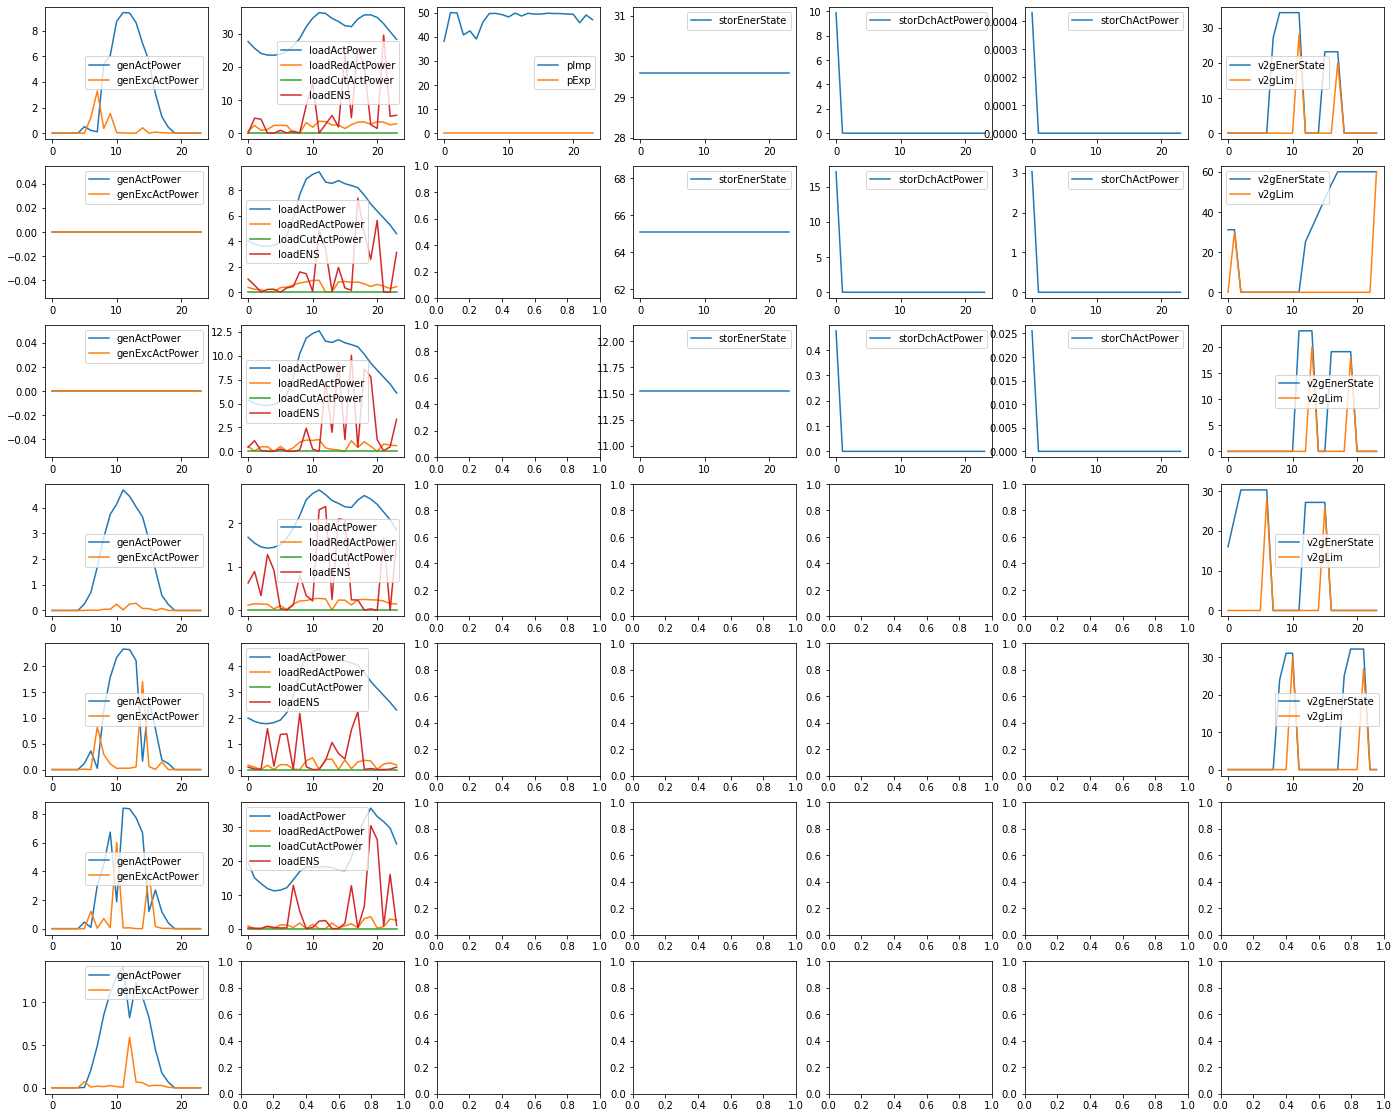

In [175]:
fig, axs = plt.subplots(nrows=7, ncols=7, figsize=(24, 20))

PLOT_SOLUTION = 0
temp_sol = list_best_instances[PLOT_SOLUTION]

for i in np.arange(7):
    # Generators
    axs[i, 0].plot(temp_sol.genActPower[i])
    axs[i, 0].plot(temp_sol.genExcActPower[i])
    axs[i, 0].legend(['genActPower', 'genExcActPower'])
    
for i in np.arange(6):
    # Loads
    axs[i, 1].plot(loadLimit[:, :, 0][i, :])
    axs[i, 1].plot(temp_sol.loadRedActPower[i])
    axs[i, 1].plot(temp_sol.loadCutActPower[i])
    axs[i, 1].plot(temp_sol.loadENS[i])
    axs[i, 1].legend(['loadActPower', 'loadRedActPower', 'loadCutActPower', 'loadENS'])


axs[0, 2].plot(temp_sol.pImp)
axs[0, 2].plot(temp_sol.pExp)
axs[0, 2].legend(['pImp', 'pExp'])


for i in range(3):
    axs[i, 3].plot(temp_sol.storEnerState[i])
    axs[i, 3].legend(['storEnerState'])
    
for i in range(3):
    axs[i, 4].plot(temp_sol.storDchActPower[i])
    axs[i, 4].legend(['storDchActPower'])
    
for i in range(3):
    axs[i, 5].plot(temp_sol.storChActPower[i])
    axs[i, 5].legend(['storChActPower'])

for i in range(5):
    axs[i, 6].plot(temp_sol.v2gEnerState[i])
    axs[i, 6].plot(v2gLimit[i, :, 2])
    axs[i, 6].legend(['v2gEnerState', 'v2gLim'])


plt.show()

In [45]:
# Total import costs

print('Total import cost: {}'.format(sum(temp_decodedsol['pImp'].ravel() * buyPrice)))

Total import cost: 74.38385281564126
